# epitopepredict API basic usage

## Methodology

Predictors for each method inherit from the `Predictor` class and all implement a predict method for scoring a single sequence. This may wrap methods from other modules and/or call command line predictors. For example the `TepitopePredictor` uses the `mhcpredict.tepitope` module. This method should return a Pandas `DataFrame`. The `predictProteins` method is used for multiple proteins contained in a dataframe of sequences in a standard format. This is created from a genbank or fasta file (see examples below). For large numbers of sequences predictProteins you should provide a path so that the results are saved as each protein is completed to avoid memory issues, since many alleles might be called for each protein. Results are saved with one file per protein in csv format. Results can be loaded into the predictor individually or all together using the `load` method.

In [38]:
import os, math, time, pickle, subprocess
from importlib import reload
from collections import OrderedDict
import numpy as np
import pandas as pd
import epitopepredict as ep
from epitopepredict import sequtils, tepitope, plotting, utilities, peptutils
from IPython.display import display, HTML, Image
%matplotlib inline
import matplotlib as mpl

In [18]:
#get preset alleles
m2_alleles = ep.get_preset_alleles('mhc2_supertypes')
m1_alleles = ep.get_preset_alleles('mhc1_supertypes')
print (m1_alleles)
print (m2_alleles)

['HLA-A*01:01', 'HLA-A*02:01', 'HLA-A*03:01', 'HLA-A*24:02', 'HLA-B*07:02', 'HLA-B*44:03']
['HLA-DRB1*01:01', 'HLA-DRB1*03:01', 'HLA-DRB1*04:01', 'HLA-DRB1*07:01', 'HLA-DRB1*08:01', 'HLA-DRB1*11:01', 'HLA-DRB1*13:01', 'HLA-DRB1*15:01']


## predict random peptides

In [27]:
seqs = peptutils.create_random_sequences(500)
print (seqs[:5])
df = pd.DataFrame(seqs,columns=['peptide'])
P = ep.get_predictor('mhcflurry')
b = P.predict_peptides(df.peptide, alleles=m1_alleles, show_cmd=True, cpus=1)

['RRWALQFAC', 'HAILSRLFP', 'NMVKMTAGG', 'NTSSGNWDG', 'QWIMHHCQR']


## results are returned as dataframes, sorted by score

In [24]:
b.head()

,peptide,pos,allele,prediction,prediction_percentile,name,score,rank
0,VTEIWCHHF,115,HLA-A*01:01,128.587237,0.239875,,128.587237,1.0
1,FVHMIWEDY,24,HLA-A*01:01,900.565410,0.840500,,900.565410,2.0
2,VAYDKHLHY,230,HLA-A*01:01,1528.042754,1.153625,,1528.042754,3.0
3,YMSMFNWKV,244,HLA-A*01:01,2227.032530,1.466250,,2227.032530,4.0
4,WTNPNIHQA,364,HLA-A*01:01,2572.773864,1.623125,,2572.773864,5.0


## predict n-mers from a protein sequence
This example loads protein sequences from mycobacterium tuberculosis from a genbank file

In [14]:
#load protein sequences into a dataframe
prots = ep.genbank_to_dataframe('../MTB-H37Rv.gb',cds=True)
prots[:5]

,type,protein_id,locus_tag,gene,db_xref,product,note,translation,pseudo,start,end,strand,length,order
2,CDS,CCP42723.1,Rv0001,dnaA,GI:444893470,Chromosomal replication initiator protein DnaA,"Rv0001, (MT0001, MTV029.01, P49993), len: 507 ...",MTDDPGSGFTTVWNAVVSELNGDPKVDDGPSSDANLSAPLTPQQRA...,NaN,0,1524,1,507,1
4,CDS,CCP42724.1,Rv0002,dnaN,GI:444893471,DNA polymerase III (beta chain) DnaN (DNA nucl...,"Rv0002, (MTV029.02, MTCY10H4.0), len: 402 aa. ...",MDAATTRVGLTDLTFRLLRESFADAVSWVAKNLPARPAVPVLSGVL...,NaN,2051,3260,1,402,2
6,CDS,CCP42725.1,Rv0003,recF,GI:444893472,DNA replication and repair protein RecF (singl...,"Rv0003, (MTCY10H4.01), len: 385 aa. RecF, DNA ...",MYVRHLGLRDFRSWACVDLELHPGRTVFVGPNGYGKTNLIEALWYS...,NaN,3279,4437,1,385,3
8,CDS,CCP42726.1,Rv0004,NaN,GI:444893473,Conserved hypothetical protein,"Rv0004, (MTCY10H4.02), len: 187 aa. Conserved ...",MTGSVDRPDQNRGERSMKSPGLDLVRRTLDEARAAARARGQDAGRG...,NaN,4433,4997,1,187,4
10,CDS,CCP42727.1,Rv0005,gyrB,GI:444893474,DNA gyrase (subunit B) GyrB (DNA topoisomerase...,"Rv0005, (MTCY10H4.03), len: 675 aa. GyrB, DNA ...",MAAQKKKAQDEYGAASITILEGLEAVRKRPGMYIGSTGERGLHHLI...,NaN,5239,7267,1,675,5


In [32]:
P = ep.get_predictor('tepitope')
mb_binders = P.predict_sequences(prots[:20], alleles=m2_alleles, cpus=1)

predictions done for 20 sequences in 8 alleles


In [33]:
mb_binders.head()

,peptide,core,pos,score,name,allele,rank
174,DTFVIGASNRF,FVIGASNRF,174,2.00,Rv0001,HLA-DRB1*0101,1.0
175,TFVIGASNRFA,FVIGASNRF,175,2.00,Rv0001,HLA-DRB1*0101,1.0
176,FVIGASNRFAH,FVIGASNRF,176,2.00,Rv0001,HLA-DRB1*0101,1.0
45,AWLNLVQPLTI,LNLVQPLTI,45,1.55,Rv0001,HLA-DRB1*0101,4.0
46,WLNLVQPLTIV,LNLVQPLTI,46,1.55,Rv0001,HLA-DRB1*0101,4.0


## get promiscuous binders - those peptides above the cutoff for at least 3 alleles

In [13]:
pb = P.promiscuous_binders(n=3)
pb.shape

(186, 8)

In [15]:
pb[:3]

,peptide,pos,name,alleles,core,score,mean,median_rank
43,AILMLYTIVII,359,Rv0017c,8,ILMLYTIVI,6.32,4.120195,16.0
386,GLVMIHRLDLV,91,Rv0017c,7,LVMIHRLDL,8.10,5.093849,1.0
733,LRIMQAQLLAK,136,Rv0004,7,LRIMQAQLL,6.80,4.135143,1.0


## plot binders in a protein sequence

['Rv0001', 'Rv0002', 'Rv0003', 'Rv0004', 'Rv0005', 'Rv0006', 'Rv0007', 'Rv0008c', 'Rv0009', 'Rv0010c', 'Rv0011c', 'Rv0012', 'Rv0013', 'Rv0014c', 'Rv0015c', 'Rv0016c', 'Rv0017c', 'Rv0018c', 'Rv0019c', 'Rv0020c']
Rv0011c tepitope 82 11 93


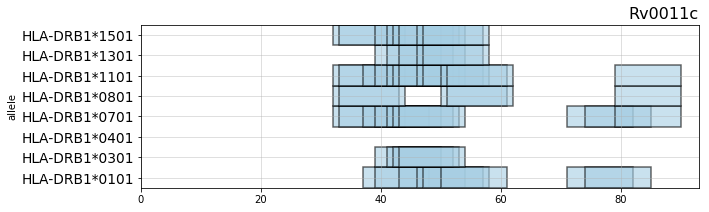

In [41]:
#get names of proteins stored in results of predictor
print (P.get_names())
ax = plotting.plot_tracks([P],name='Rv0011c',cutoff=.95,n=2)